# A4 Classification of Hand-Drawn Digits

In this assignment, you will define a new class named `NeuralNetworkClassifier` that extends the `NeuralNetwork` class provided here and is the solution to Assignment A2.  You will use `NeuralNetworkClassifier` to train a classifier of hand-drawn digits.

You will also define the function `confusion_matrix`.

## `NeuralNetwork` class

In [71]:
import matplotlib.pyplot as plt

The following code cell will write its contents to `optimizers.py` so the `import optimizers` statement in the code cell after it will work correctly.

In [72]:
%%writefile optimizers.py
import numpy as np

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing m, v, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Overwriting optimizers.py


In [73]:
import numpy as np
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        # Unstandardize output Y before returning it
        return Y * self.Tstds + self.Tmeans

Adam: Epoch 25 Error=0.24555
Adam: Epoch 50 Error=0.21393
Adam: Epoch 75 Error=0.17066
Adam: Epoch 100 Error=0.11181
Adam: Epoch 125 Error=0.08114
Adam: Epoch 150 Error=0.06963
Adam: Epoch 175 Error=0.06214
Adam: Epoch 200 Error=0.05597
Adam: Epoch 225 Error=0.05058
Adam: Epoch 250 Error=0.04578


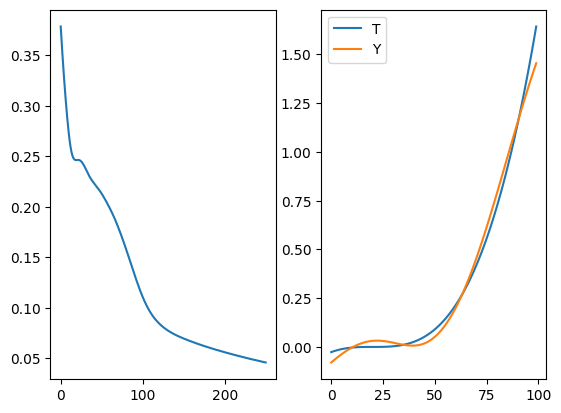

In [74]:
X = np.arange(100).reshape((-1, 1))
T = (X - 20) ** 3 / 300000

hiddens = [10]
nnet = NeuralNetwork(X.shape[1], hiddens, T.shape[1])
nnet.train(X, T, 250, 0.01, method='adam')

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)

plt.subplot(1, 2, 2)
plt.plot(T, label='T')
plt.plot(nnet.use(X), label='Y')
plt.legend()

## Your `NeuralNetworkClassifier` class

Complete the following definition of `NeuralNetworkClassifier` as discussed in class. You will need to override the functions

* `train`
* `error_f`
* `gradient_f`
* `use`

and define the following new functions

* `makeIndicatorVars`
* `softmax`

In [75]:
class NeuralNetworkClassifier(NeuralNetwork):
    
    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):

        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1
            self.Classes = np.unique(T)
            
        X = (X - self.Xmeans) / self.Xstds
        
        T = self.makeIndicatorVars(T)
        
        optimizer = optimizers.Optimizers(self.all_weights)

        to_likelihood = lambda nll: np.exp(-nll)

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=True,
                                        error_convert_f=to_likelihood)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=True,
                                         error_convert_f=to_likelihood)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        return self

    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        Y = self.softmax(Ys[-1])
        cross_entropy_error = -np.mean(np.log(Y) * T)
        return cross_entropy_error

    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        Ys = self.forward_pass(X)
        error = T - self.softmax(Ys[-1])
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y_prob = self.softmax(Ys[-1])
        Y_predicted = np.argmax(Y_prob, axis=1)
        Y_labeled = np.array([[self.Classes[i]] for i in Y_predicted])
        return Y_labeled, Y_prob
        
    def makeIndicatorVars(self, T):
        if T.ndim == 1:
            T = T.reshape((-1, 1))    
        return (T == np.unique(T)).astype(int)

    def softmax(self, Y):
        expY = np.exp(Y)
        expY_sum = np.sum(expY, axis=1, keepdims=True)
        return expY / expY_sum

Here is a simple test of your new class.  For inputs from 0 to 100, classify values less than or equal to 25 as Class Label 25, greater than 25 and less than or equal to 75 as Class Label 75, and greater than 75 as Class Label 100. 

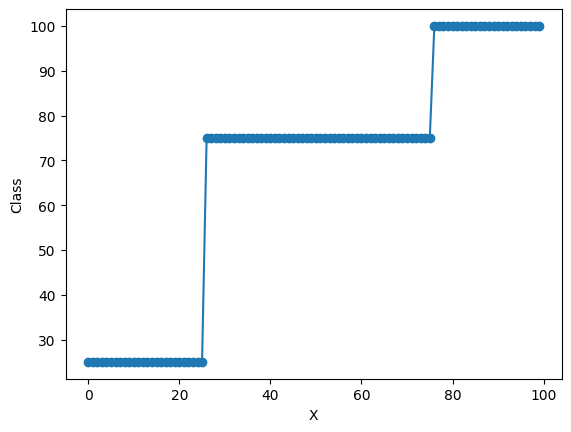

In [76]:
X = np.arange(100).reshape((-1, 1))
T = X.copy()
T[T <= 25] = 25
T[np.logical_and(25 < T, T <= 75)] = 75
T[T > 75] = 100

plt.plot(X, T, 'o-')
plt.xlabel('X')
plt.ylabel('Class');

Adam: Epoch 20 Error=0.77054
Adam: Epoch 40 Error=0.85069
Adam: Epoch 60 Error=0.90481
Adam: Epoch 80 Error=0.93414
Adam: Epoch 100 Error=0.94962
Adam: Epoch 120 Error=0.95857
Adam: Epoch 140 Error=0.96439
Adam: Epoch 160 Error=0.96854
Adam: Epoch 180 Error=0.97167
Adam: Epoch 200 Error=0.97414


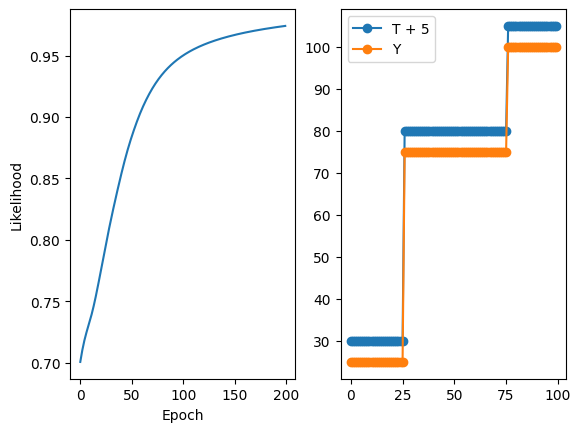

In [77]:
hiddens = [10]
nnet = NeuralNetworkClassifier(X.shape[1], hiddens, len(np.unique(T)))
nnet.train(X, T, 200, 0.01, method='adam', verbose=True)

plt.subplot(1, 2, 1)
plt.plot(nnet.error_trace)
plt.xlabel('Epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T + 5, 'o-', label='T + 5')  # to see, when predicted overlap T very closely
plt.plot(nnet.use(X)[0], 'o-', label='Y')
plt.legend()

## Now for the Hand-Drawn Digits

We will use a bunch (50,000) images of hand drawn digits from [this deeplearning.net site](http://deeplearning.net/tutorial/gettingstarted.html).  Download `mnist.pkl.gz`. 

deeplearning.net goes down a lot.  If you can't download it from there you can try getting it from [here](https://gitlab.cs.washington.edu/colinxs/neural_nets/blob/master/mnist.pkl.gz).

This pickle file includes data already partitioned into training, validation, and test sets.  To read it into python, use the following steps

In [78]:
import pickle
import gzip

with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


In [79]:
Ttrain[:10]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4]])

Those must be the digits.  What the heck is in those 784 columns in the input matrices?

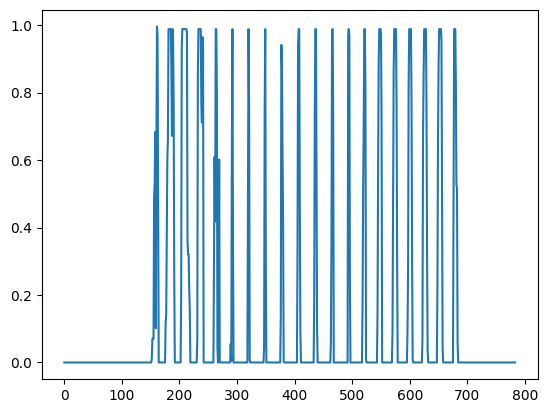

In [80]:
plt.plot(Xtrain[0, :]);

Well, values between 0 and 1.  That doesn't help much.  These are actually intensity values for 784 pixels in an image.

How can we rearrange these values into an image to be displayed?  We must first figure out how many columns and rows the image would have.  Perhaps the image is a square image, with equal numbers of rows and columns.

In [81]:
import math
math.sqrt(784)

28.0

Ah, cool.

In [82]:
28 * 28

784

Ok Let's reshape it and look at the numbers.

In [83]:
image0 = Xtrain[0, :]
image0 = image0.reshape(28, 28)
image0

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

Not that helpful.  Ok, let's use `matplotlib` to make an image display.

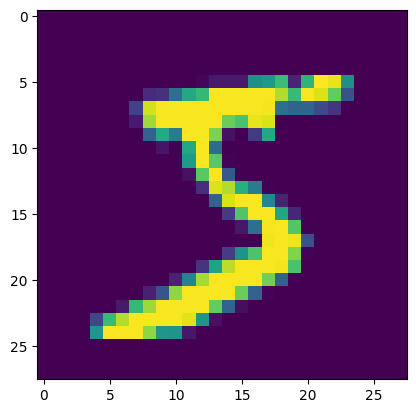

In [84]:
plt.imshow(image0);

Humm.  Try a grayscale color map.

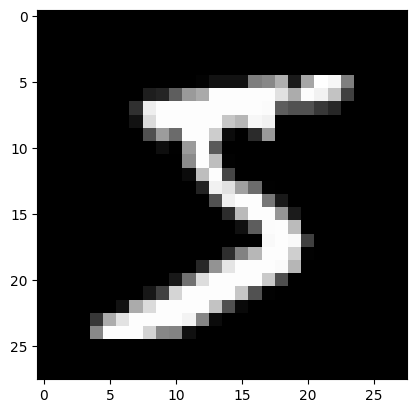

In [85]:
plt.imshow(image0, cmap='gray');

With a little more work, we can make it look like a pencil drawing.

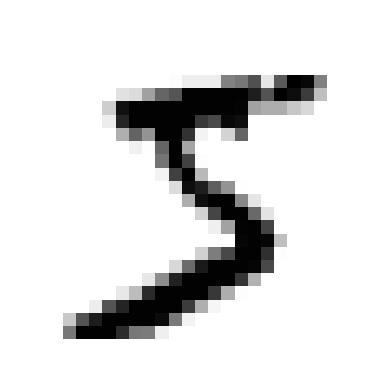

In [86]:
plt.imshow(-image0, cmap='gray')  # notice the negative sign
plt.axis('off');

Looks like a 5.  What class label is associated with this image?

In [87]:
Ttrain[0]

array([5])

Okay.  Makes sense.  Let's look at the first 100 images and their labels, as plot titles.

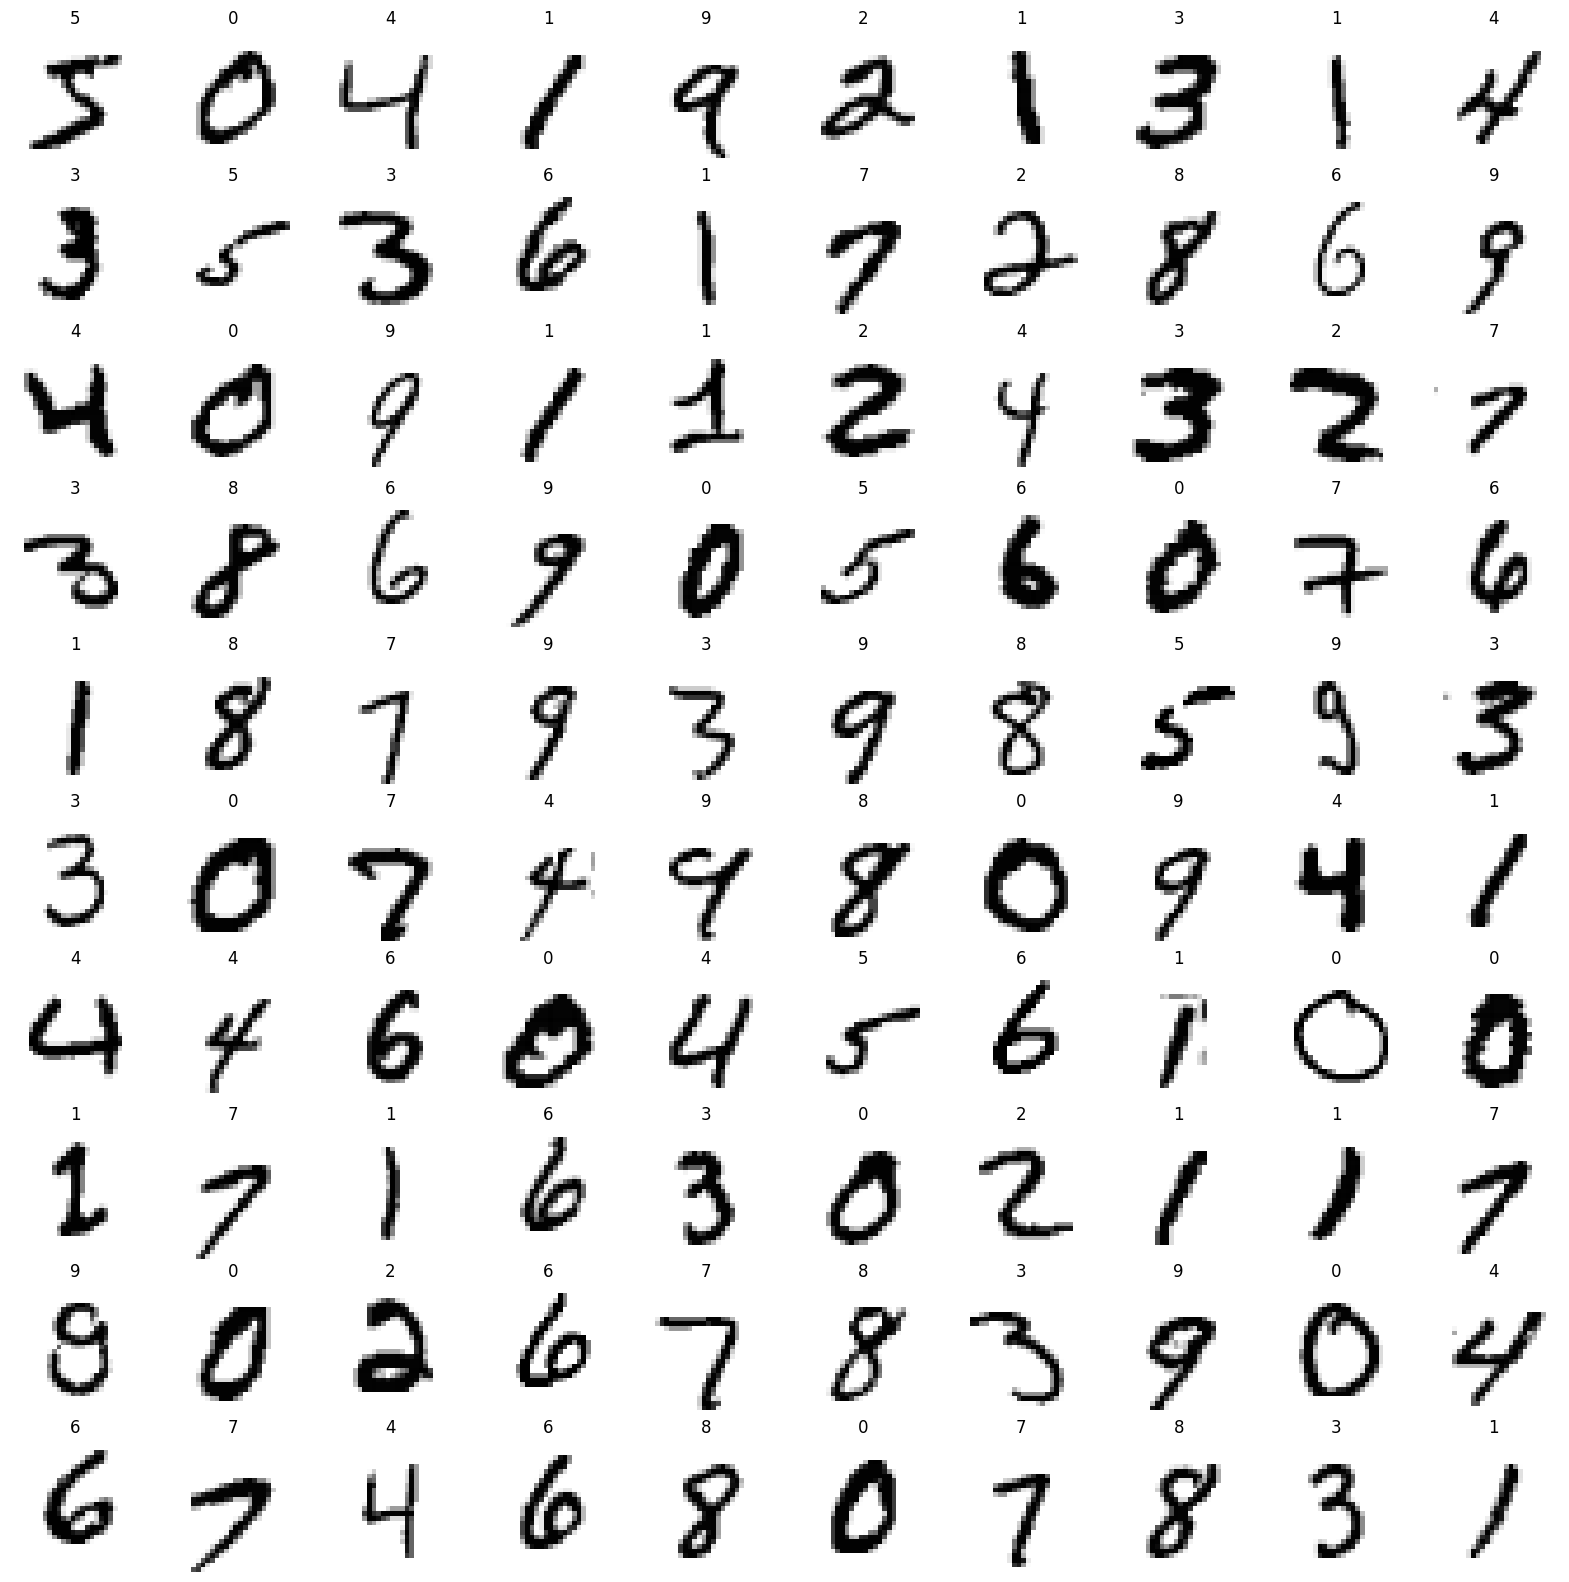

In [88]:
plt.figure(figsize=(20, 20))
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(-Xtrain[i, :].reshape(28, 28), cmap='gray')
    plt.title(Ttrain[i, 0])
    plt.axis('off');

Okay.  We are ready to try to classify, right?

First we should check the proportions of each digit in the given data partitions.

In [89]:
classes = np.arange(10)
(Ttrain == classes).shape

(50000, 10)

In [90]:
(Ttrain == classes).sum(axis=0)

array([4932, 5678, 4968, 5101, 4859, 4506, 4951, 5175, 4842, 4988])

In [91]:
(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]

array([0.09864, 0.11356, 0.09936, 0.10202, 0.09718, 0.09012, 0.09902,
       0.1035 , 0.09684, 0.09976])

In [92]:
['Ttrain', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]]

['Ttrain',
 0.09864,
 0.11356,
 0.09936,
 0.10202,
 0.09718,
 0.09012,
 0.09902,
 0.1035,
 0.09684,
 0.09976]

In [93]:
import pandas

result = []
result.append(['Train', *(Ttrain == classes).sum(axis=0) / Ttrain.shape[0]])
result.append(['Tval', *(Tval == classes).sum(axis=0) / Tval.shape[0]])
result.append(['Ttest', *(Ttest == classes).sum(axis=0) / Ttest.shape[0]])
pandas.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,10
0,Train,0.09864,0.11356,0.09936,0.10202,0.09718,0.09012,0.09902,0.1035,0.09684,0.09976
1,Tval,0.09910,0.10640,0.09900,0.10300,0.09830,0.09150,0.09670,0.1090,0.10090,0.09610
2,Ttest,0.09800,0.11350,0.10320,0.10100,0.09820,0.08920,0.09580,0.1028,0.09740,0.10090


All very close to 0.1. Super.

Time for our first experiment.  Let's train a small neural net with 5 hidden units in one layer for a small number of epochs using Adam.

In [94]:
n_epochs = 100
learning_rate = 0.01

np.random.seed(142)

nnet = NeuralNetworkClassifier(Xtrain.shape[1], [5], len(classes))
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

Adam: Epoch 10 Error=0.82887
Adam: Epoch 20 Error=0.85170
Adam: Epoch 30 Error=0.87229
Adam: Epoch 40 Error=0.88913
Adam: Epoch 50 Error=0.90202
Adam: Epoch 60 Error=0.91179
Adam: Epoch 70 Error=0.91932
Adam: Epoch 80 Error=0.92541
Adam: Epoch 90 Error=0.93041
Adam: Epoch 100 Error=0.93447


NeuralNetworkClassifier(784, [5], 10, 'tanh')

In [95]:
print(nnet)  # uses the __str__ method

NeuralNetworkClassifier(784, [5], 10, 'tanh') trained for 100 epochs, final training error 0.9345


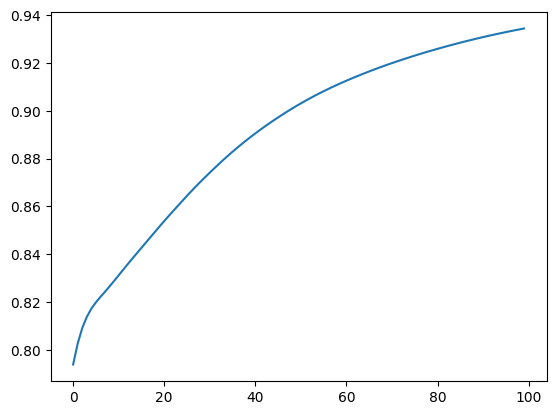

In [96]:
plt.plot(nnet.error_trace);

Now it is time for you to run some longer experiments.  You must write the code to do the following steps:

1. For each of at least five different hidden layer structures

    1. Train a network for 500 epochs.
    1. Collect percent of samples correctly classified in the given train, validate, and test partitions.

2. Create a `pandas.DataFrame` with these results and with column headings `('Hidden Layers', 'Train', 'Validate', 'Test', 'Time')` where `'Time'` is the number of seconds required to train each network.

3. Retrain a network using the best hidden layer structure, judged by the percent correct on the validation set.
4. Use this network to find several images in the test set for which the network's probability of the correct class is the closest to zero, meaning images for which your network does the worst.  Draw these images and discuss why your network might not be doing well for those images.

In [97]:
import time

n_epochs = 500
learning_rate = 0.01
n_hidden_units_per_layer_choices = [[10], [100], [5, 10], [25, 25], [100, 100]]
n_inputs = Xtrain.shape[1]
n_outputs = Ttrain.shape[1]
param_vals = []
best_arch = [0, 0, 0, 0, 0]
    
for n_hidden in n_hidden_units_per_layer_choices:
    start = time.time()
    
    nnet = NeuralNetworkClassifier(n_inputs, n_hidden, len(np.unique(Ttrain)))
    nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)
    
    Ytrain_c, Ytrain_p = nnet.use(Xtrain)
    train_perc = (Ytrain_c == Ttrain).sum(axis=0) / Ttrain.shape[0]
    Yval_c, Yval_p = nnet.use(Xval)
    val_perc = (Yval_c == Tval).sum(axis=0) / Tval.shape[0]
    Ytest_c, Ytest_p = nnet.use(Xtest)
    test_perc =  (Ytest_c == Ttest).sum(axis=0) / Ttest.shape[0]
    
    elapsed_time = (time.time() - start)
    param_iter = [n_hidden, train_perc, val_perc, test_perc, elapsed_time ]
    if np.max(param_iter[2]) > np.max(best_arch[2]):
        best_arch = param_iter
    param_vals.append(param_iter)
    
    print(f'Took {elapsed_time:.2f} seconds for the architecture {n_hidden}') 
    
nn_df = pandas.DataFrame(param_vals)
nn_df.columns = ['Hidden Layers', 'Train', 'Validate', 'Test', 'Time']
print(f'The best architecture is {best_arch[0]}')
nn_df

Adam: Epoch 50 Error=0.94796
Adam: Epoch 100 Error=0.96474
Adam: Epoch 150 Error=0.97076
Adam: Epoch 200 Error=0.97404
Adam: Epoch 250 Error=0.97603
Adam: Epoch 300 Error=0.97747
Adam: Epoch 350 Error=0.97865
Adam: Epoch 400 Error=0.97953
Adam: Epoch 450 Error=0.98020
Adam: Epoch 500 Error=0.98076
Took 356.76 seconds for the architecture [10]
Adam: Epoch 50 Error=0.98527
Adam: Epoch 100 Error=0.99236
Adam: Epoch 150 Error=0.99563
Adam: Epoch 200 Error=0.99729
Adam: Epoch 250 Error=0.99818
Adam: Epoch 300 Error=0.99870
Adam: Epoch 350 Error=0.99901
Adam: Epoch 400 Error=0.99923
Adam: Epoch 450 Error=0.99939
Adam: Epoch 500 Error=0.99950
Took 610.09 seconds for the architecture [100]
Adam: Epoch 50 Error=0.87037
Adam: Epoch 100 Error=0.92309
Adam: Epoch 150 Error=0.94089
Adam: Epoch 200 Error=0.94879
Adam: Epoch 250 Error=0.95300
Adam: Epoch 300 Error=0.95626
Adam: Epoch 350 Error=0.95861
Adam: Epoch 400 Error=0.96004
Adam: Epoch 450 Error=0.96126
Adam: Epoch 500 Error=0.96189
Took 451.7

,Hidden Layers,Train,Validate,Test,Time
0,[10],[0.94876],[0.9056],[0.8961],356.760021
1,[100],[0.99962],[0.9573],[0.9547],610.089020
2,"[5, 10]",[0.88626],[0.8756],[0.8604],451.738871
3,"[25, 25]",[0.9952],[0.9316],[0.921],621.584195
4,"[100, 100]",[1.0],[0.9571],[0.9562],1160.414930


In [98]:
nnet = NeuralNetworkClassifier(n_inputs, best_arch[0], len(np.unique(Ttrain)))
nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method='adam', verbose=True)

Ytrain_c, Ytrain_p = nnet.use(Xtrain)
Yval_c, Yval_p = nnet.use(Xval)
Ytest_c, Ytest_p = nnet.use(Xtest)

print(f'Took {elapsed_time:.2f} seconds.')

Adam: Epoch 50 Error=0.98532
Adam: Epoch 100 Error=0.99238
Adam: Epoch 150 Error=0.99560
Adam: Epoch 200 Error=0.99723
Adam: Epoch 250 Error=0.99813
Adam: Epoch 300 Error=0.99867
Adam: Epoch 350 Error=0.99901
Adam: Epoch 400 Error=0.99923
Adam: Epoch 450 Error=0.99939
Adam: Epoch 500 Error=0.99950
Took 1160.41 seconds.


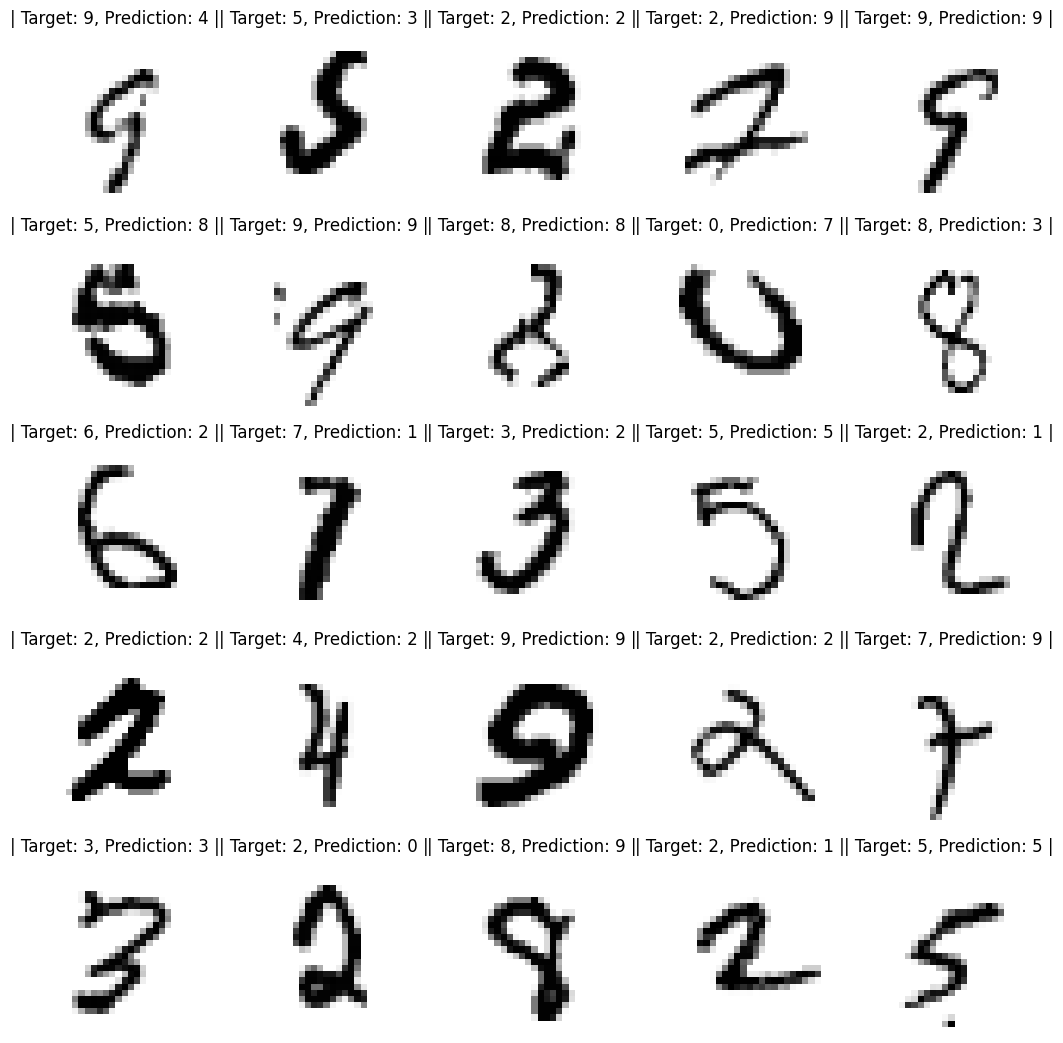

In [114]:
correct_probs = Ytest_p[np.arange(len(Ytest_c)), Ytest_c.flatten()]
lowest_indices = np.argsort(correct_probs)

plt.figure(figsize=(13, 13))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(-Xtest[lowest_indices[i], :].reshape(28, 28), cmap='gray')
    plt.title(f'| Target: {Ttest[lowest_indices[i]][0]}, Prediction: {Ytest_c[lowest_indices[i]][0]} |');
    plt.axis('off');

### Discussion

My network might not be doing well for those images because of the way they are written. For example:
- Row 1, Column 1: The target was a nine, but a 4 was predicted. This is likely due to the written 9 not being fully connected in it's loop. The area of disconnection causes an openness similar to that of an awkwardly drawn 4. If the tail of the loop was ended a bit more to the right, the model may have predicted it correctly, like in the example of Row 1, Column 5. When looking at the confusion matrices for the test set, we can also see that 4 is the most misclassfied class for target examples representing 9.
- Row 1, Column 2: The target was a 5, but the model predicted a 3. The top section of the 5, which is normally consistent of two defined angles, is lightly curved and not very defined, making is look like an S. This curvature, though facing the wrong wat, could have been representative of the curvature found in a 3. When looking at the confusion matrix for the test set, 3's, along with  6's, are the second most misclassified classes for a target example of 5. So, this misclassification is not suprising. 
- Row 2, Column 1: The target was a 5, but the model predicted an 8. This misclassification is more of a suprise to me because I feel this is pretty defined. The issue here may be due to the shortness of the line that makes the top of the 5. Due to how short it is, it is similar in shape to that of an 8 that has disconnectiong. Additionally, the tail end being to close to the midpoint could further the model's belief of the example being an 8. Something that furthers this point is the example in Row 2, Column three. It correctly classified the example as an 8, despite having multiple disconencting points within the figure.
- Row 2, Column 4: The target is a 0, but the model predicted 7. I am not entirely sure why the model misclassified this as a 7. With the disconnection at the top of the figure, I feel that if it were to misclassify the example, it would say it was a 4 or 6. The reason I think this is because the disconnection fits that of a four, while the lines of the digit cover similar spaces in the box as a 6. The more I try to think of why 7 was the predicted class, the less I can determine why. Even when consulting the confusion matrix, 7 is one of the lower misclassified values for 0. Which leads me to believe that the probabilty of all classes for this sample were very close to each other in value.
- Row 2, Column 5: The target is 8, but the model predicted 3. When consulting the confusion matrix, we can see that 8 is one of the most misclassified classes of all ten possible classes along with 9 and 5. Then, for samples of 8, when they are misclassified, the predictions are predominantly misclassified as 2, 3, 5, and 9. All of which share one or more types of curve. So, for this example, the model was likely torn between what to classify the sample as. Additionally, the cure on the lower left section of the digit is slightly faded, making the lower half of the digit resemble a 3.
- Row 3, Column 1: The target was a 6 and the model predicted a 2. When consulting the confusion matrix, 2 is not a value that 6 is often misclassified as. This misclassification is likely due to a 2 and a 6 have a similar upper loop. So, the classification between the two is largely defined by the lower section of the digit. For this example, the lower section of the 6 is cut off by the edge of the image, making the curve seem like a straight line, similarly to a two. So
- Row 3, Column 2: The target was a 7 and the model predicted 1. The issue behind this classification is pretty easy to see. The top horizontal line is short and stubby compared to other samples of 7. Then, when looking at some samples of 1, many of them have a similar stubby line at the top. When consulting the confusion matrix, this link is not entirely apparent when looking at how frequently 7s are misclassified as 1s. Though, what we can see is that 1s are most frequently misclassified as 7s. The similarity of this single line is likely what caused the misclassification.

- Overall, many of the issues seem to arise with hand drawn digits that are written in a an incomplete fashion that results in openings or shapes that make the digit resemble another in some fashion. Me may see better performance by removing the extremes of each sample, along with samples where the digit is cut off. For example we collect the misclassified samples and remove some of them in during the preprocessing step after an qualitative analysis.


## `confusion_matrix`

Now, write a function named `confusion_matrix` that returns a confusion matrix for any classification problem, returned as a `pandas.DataFrame` as shown in Lecture Notes 12.  It must require two arguments, the predicted classes for each sample and the true classes for each sample.  Here is an example.

In [115]:
import pandas as pd

def confusion_matrix(Y_classes, T):
    table = []
    class_names = np.unique(T)
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(Y_classes[T == true_class] == Y_class))
        table.append(row)
    conf_matrix = pandas.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix


conf_matrix_test = confusion_matrix(Ytest_c, Ttest)
print("Test Predictions")
conf_matrix_test.style.background_gradient(cmap='Blues').format("{:.1f}%")

Test Predictions


,0,1,2,3,4,5,6,7,8,9
0,98.1%,0.0%,0.2%,0.0%,0.0%,0.5%,0.4%,0.2%,0.3%,0.3%
1,0.0%,98.8%,0.3%,0.0%,0.0%,0.1%,0.4%,0.1%,0.4%,0.0%
2,0.8%,0.2%,94.9%,0.9%,0.8%,0.0%,0.7%,0.7%,1.0%,0.2%
3,0.1%,0.0%,0.5%,96.6%,0.2%,0.9%,0.2%,0.8%,0.6%,0.1%
4,0.1%,0.0%,0.6%,0.1%,95.6%,0.2%,1.1%,0.4%,0.2%,1.6%
5,0.3%,0.1%,0.1%,2.6%,0.4%,92.4%,1.6%,0.3%,1.6%,0.6%
6,0.7%,0.2%,0.4%,0.2%,0.2%,0.9%,96.9%,0.1%,0.3%,0.0%
7,0.1%,0.7%,1.8%,0.7%,0.2%,0.0%,0.0%,94.9%,0.2%,1.4%
8,0.5%,0.4%,0.6%,1.7%,0.7%,1.2%,0.6%,0.9%,92.9%,0.3%
9,0.5%,0.5%,0.0%,0.7%,2.4%,0.5%,0.0%,1.4%,1.2%,92.9%


In [116]:
conf_matrix_val = confusion_matrix(Yval_c, Tval)
print("Validation Predictions")
conf_matrix_val.style.background_gradient(cmap='Blues').format("{:.1f}%")

Validation Predictions


,0,1,2,3,4,5,6,7,8,9
0,97.9%,0.0%,0.3%,0.1%,0.3%,0.1%,0.6%,0.3%,0.3%,0.1%
1,0.0%,98.4%,0.4%,0.1%,0.2%,0.2%,0.0%,0.1%,0.7%,0.0%
2,0.2%,0.1%,95.5%,0.9%,0.5%,0.1%,0.4%,0.9%,1.1%,0.3%
3,0.3%,0.2%,0.5%,95.0%,0.1%,1.7%,0.2%,0.2%,1.6%,0.4%
4,0.1%,0.6%,0.4%,0.1%,96.5%,0.0%,0.1%,0.1%,0.1%,1.9%
5,0.9%,0.1%,0.7%,1.9%,0.1%,92.8%,2.2%,0.2%,0.8%,0.4%
6,0.2%,0.1%,0.1%,0.1%,0.3%,0.4%,98.7%,0.0%,0.1%,0.0%
7,0.2%,0.3%,0.7%,0.4%,0.4%,0.2%,0.0%,96.8%,0.2%,0.9%
8,0.2%,0.6%,0.9%,1.5%,0.2%,1.2%,0.7%,0.6%,92.9%,1.3%
9,0.4%,0.3%,0.2%,0.9%,1.6%,0.5%,0.0%,1.5%,0.5%,94.1%


In [117]:
conf_matrix_train = confusion_matrix(Ytrain_c, Ttrain)
print("Train Predictions")
conf_matrix_train.style.background_gradient(cmap='Blues').format("{:.1f}%")

Train Predictions


,0,1,2,3,4,5,6,7,8,9
0,99.9%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
1,0.0%,99.9%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
2,0.0%,0.0%,99.9%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
3,0.0%,0.0%,0.0%,99.9%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
4,0.0%,0.0%,0.0%,0.0%,99.9%,0.0%,0.0%,0.0%,0.0%,0.0%
5,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%,0.0%
6,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%,0.0%
7,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%,0.0%
8,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,100.0%,0.0%
9,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,99.9%


## Grading and Check-In

You will receive 50 points for correct code, and 50 points for other results and your discussions.  As before, you can test your code against the grading script yourself by downloading [A4grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A4grader.zip) and extracting `A4grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the in the following cell to see an example grading run.  Submit assignments **through Canvas** following the pattern of the previous assignments. *Do not send your file to the instructor/TA via email or any other medium!*

In [118]:
%run -i A4grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Youngren-A4.ipynb' and storing in notebookcode.py


[NbConvertApp] Converting notebook Youngren-A4.ipynb to script


Removing all statements that are not function or class defs or import statements.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.forward_pass.__func__ == nn_class.forward_pass.__func__


--- 5/5 points.  Function NeuralNetwork.forward_pass is correctly not overridden in NeuralNetworkClassifier.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.train.__func__ != nn_class.train.__func__


--- 5/5 points.  Function NeuralNetwork.train is correctly overridden in NeuralNetworkClassifier.

Testing

    nn_reg = NeuralNetwork(1, [5], 2)
    nn_class = NeuralNetworkClassifier(1, [5], 5)

    nn_reg.use.__func__ != nn_class.use.__func__


--- 5/5 points.  Function NeuralNetwork.use is correctly overridden in NeuralNetworkClassifier.

Testing

    nn_class = NeuralNetworkClassifier(1, [5], 5)
    result = nn_class.makeIndicatorVars(np.arange(5).reshape(-1, 1))



--- 5/5 poi

## Extra Credit
Earn 5 extra credit point on this assignment by doing the following.

1. Combine the train, validate, and test partitions loaded from the MNIST data file into two matrices, `X` and `T`. 
2. Using `adam` , `relu` and just one value of `learning_rate` and `n_epochs`, compare several hidden layer architectures. Do so by applying our `generate_k_fold_cross_validation_sets` function as defined in Lecture Notes 10 which forms stratified partitioning, for use in classification problems, to your `X` and `T` matrices using `n_fold` of 3.
3. Show results and discuss which architectures you find works the best, and how you determined this.

In [125]:
def generate_stratified_partitions(X, T, n_folds, validation=True, shuffle=True):
    '''Generates sets of  Xtrain,Ttrain,Xvalidate,Tvalidate,Xtest,Ttest
      or
       sets of Xtrain,Ttrain,Xtest,Ttest if validation is False
    Build dictionary keyed by class label. Each entry contains rowIndices and start and stop
    indices into rowIndices for each of n_folds folds'''

    def rows_in_fold(folds, k):
        all_rows = []
        for c, rows in folds.items():
            class_rows, starts, stops = rows
            all_rows += class_rows[starts[k]:stops[k]].tolist()
        return all_rows

    def rows_in_folds(folds, ks):
        all_rows = []
        for k in ks:
            all_rows += rows_in_fold(folds, k)
        return all_rows

    row_indices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(row_indices)
    folds = {}
    classes = np.unique(T)
    for c in classes:
        class_indices = row_indices[np.where(T[row_indices, :] == c)[0]]
        n_in_class = len(class_indices)
        n_each = int(n_in_class / n_folds)
        starts = np.arange(0, n_each * n_folds, n_each)
        stops = starts + n_each
        stops[-1] = n_in_class
        folds[c] = [class_indices, starts, stops]

    for test_fold in range(n_folds):
        if validation:
            for validate_fold in range(n_folds):
                if test_fold == validate_fold:
                    continue
                train_folds = np.setdiff1d(range(n_folds), [test_fold, validate_fold])
                rows = rows_in_fold(folds, test_fold)
                Xtest = X[rows, :]
                Ttest = T[rows, :]
                rows = rows_in_fold(folds, validate_fold)
                Xvalidate = X[rows, :]
                Tvalidate = T[rows, :]
                rows = rows_in_folds(folds, train_folds)
                Xtrain = X[rows, :]
                Ttrain = T[rows, :]
                yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest
        else:
            # No validation set
            train_folds = np.setdiff1d(range(n_folds), [test_fold])
            rows = rows_in_fold(folds, test_fold)
            Xtest = X[rows, :]
            Ttest = T[rows, :]
            rows = rows_in_folds(folds, train_folds)
            Xtrain = X[rows, :]
            Ttrain = T[rows, :]
            yield Xtrain, Ttrain, Xtest, Ttest

In [126]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func = 'relu', method = 'adam'):
    best_arch = [0, 0, 0, 0, 0]
    param_vals = []
    for n_hidden in list_of_n_hiddens:
        folds = []
        start = time.time()
        for Xtrain, Ttrain, Xval, Tval, Xtest, Ttest in \
                generate_stratified_partitions(X, T, n_folds):
            
            n_inputs = Xtrain.shape[1]
            n_outputs = len(np.unique(T))
            nnet = NeuralNetworkClassifier(n_inputs, hiddens, n_outputs, act_func)
            nnet.train(Xtrain, Ttrain, n_epochs, learning_rate, method)
            Ytrain_c, Ytrain_p = nnet.use(Xtrain)
            train_perc = (Ytrain_c == Ttrain).sum(axis=0) / Ttrain.shape[0]
            Yval_c, Yval_p = nnet.use(Xval)
            val_perc = (Yval_c == Tval).sum(axis=0) / Tval.shape[0]
            Ytest_c, Ytest_p = nnet.use(Xtest)
            test_perc =  (Ytest_c == Ttest).sum(axis=0) / Ttest.shape[0]
                    
            elapsed_time = (time.time() - start)
            param_iter = [n_hidden, train_perc, val_perc, test_perc, elapsed_time]
            if np.max(param_iter[2]) > np.max(best_arch[2]):
                best_arch = param_iter
            param_vals.append(param_iter)
        print(f'Took {elapsed_time:.2f} seconds for the architecture {n_hidden} with {n_folds} folds') 
            
    nnsp_df = pandas.DataFrame(param_vals)
    nnsp_df.columns = ['Hidden Layers','Train', 'Validate', 'Test', 'Time']
    print(f'The best architecture is {best_arch[0]}')
    return nnsp_df, best_arch

In [127]:
n_folds = 3
list_of_n_hiddens = [[10], [25], [100], [5, 10], [10, 5], [10, 10], 
                     [25, 25], [50, 75], [10, 10, 10], [25, 25, 25]   ]
n_epochs = 300
learning_rate = 0.001
X = np.vstack((Xtrain, Xval, Xtest))
T = np.vstack((Ttrain, Tval, Ttest))

nnsp_df, best_arch = run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                    n_epochs, learning_rate)

nnsp_df

Adam: Epoch 30 Error=0.84144
Adam: Epoch 60 Error=0.88294
Adam: Epoch 90 Error=0.91755
Adam: Epoch 120 Error=0.94265
Adam: Epoch 150 Error=0.95488
Adam: Epoch 180 Error=0.96150
Adam: Epoch 210 Error=0.96564
Adam: Epoch 240 Error=0.96850
Adam: Epoch 270 Error=0.97063
Adam: Epoch 300 Error=0.97232
Adam: Epoch 30 Error=0.83851
Adam: Epoch 60 Error=0.87835
Adam: Epoch 90 Error=0.90679
Adam: Epoch 120 Error=0.92513
Adam: Epoch 150 Error=0.94222
Adam: Epoch 180 Error=0.95446
Adam: Epoch 210 Error=0.95991
Adam: Epoch 240 Error=0.96346
Adam: Epoch 270 Error=0.96609
Adam: Epoch 300 Error=0.96820
Adam: Epoch 30 Error=0.84224
Adam: Epoch 60 Error=0.88147
Adam: Epoch 90 Error=0.91512
Adam: Epoch 120 Error=0.93899
Adam: Epoch 150 Error=0.95234
Adam: Epoch 180 Error=0.95889
Adam: Epoch 210 Error=0.96290
Adam: Epoch 240 Error=0.96580
Adam: Epoch 270 Error=0.96808
Adam: Epoch 300 Error=0.96995
Adam: Epoch 30 Error=0.83657
Adam: Epoch 60 Error=0.87214
Adam: Epoch 90 Error=0.90533
Adam: Epoch 120 Error=

,Hidden Layers,Train,Validate,Test,Time
0,[10],[0.9202588053817807],[0.9036475076079037],[0.9053619647679053],112.734525
1,[10],[0.9087480176589088],[0.8924929299854315],[0.8938751017958939],225.419362
2,[10],[0.9126746079355558],[0.8996613947108997],[0.8968325403968969],338.572010
3,[10],[0.9084479876559084],[0.8958779672636901],[0.8916034460588916],447.594991
4,[10],[0.911962624833912],[0.8975183232608975],[0.8996486417002314],555.597860
5,[10],[0.9078479276499078],[0.892932150357893],[0.8934784471677093],665.276278
6,[25],[0.9143028537149713],[0.903947537610904],[0.905019073335905],109.329242
7,[25],[0.9185204234709186],[0.9009769474676493],[0.9037332304659037],218.553334
8,[25],[0.9159310994943869],[0.9017187433029017],[0.9007329304359007],331.043089
9,[25],[0.9105910591059105],[0.8955780272516926],[0.8960610346748961],437.730044


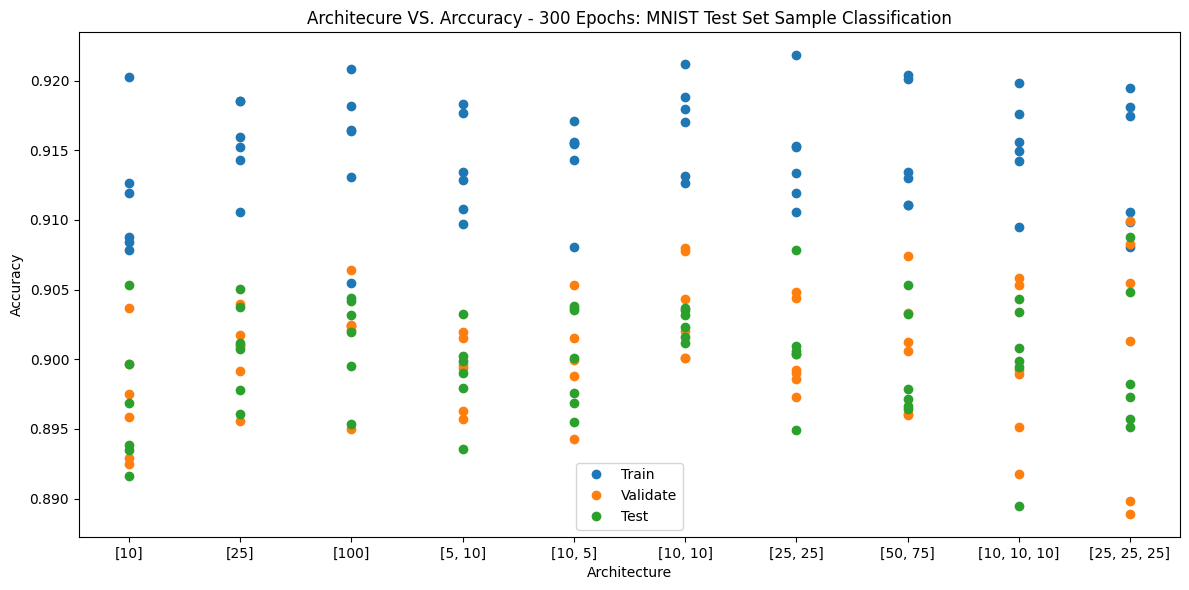

In [136]:
def plot_results(results):
    accuracies = results.iloc[:, 1:-1].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.figure(figsize=(12, 6))
    plt.plot(archs, accuracies, 'o')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.xlabel('Architecture')
    plt.ylabel('Accuracy')
    plt.title("Architecure VS. Arccuracy - 300 Epochs: MNIST Test Set Sample Classification")
    plt.tight_layout()

plot_results(nnsp_df)

### Extra Credit Discussion

I ran into many issues for this assignment through the last week and a half and with how long it takes everything to run, it prolonged the process. Especially in scerios where I had to shut down my laptop. So, this description may not be my best, but I will try my best in the last 20 minutes I have.

In all cases, the accuracies of the test and validation set don't quite line up with the train set. Whether we will see thes probabilities align further is unknown.

Most of the accuracies seem to be worse than the analysis prior. This may be due to the way relu and adam interact. So, for future analysis, tanh may be the best activation function with adam optimization. We may see sgd interact better with relu, but this is currently unknown.

From this graph, we see that we get more consistentcy in the architecture [10, 10] because all of the accruaccies a groups closer together. Though, the architecture that performs best on the validation and test sets is the more complex option, [25, 25, 25]. On the other hand, we see some of the worst validation accuracies with this same architecture. 

Give the spread of lower variance of accuracies for the [10, 10], [25, 25], and [50, 75], architectures consisting of two layers may be best for this data set. We may see accuracy improvements with an increased number of units, but whether this will help is still an unknown. If I had the time, I would want to pursue more 2 layered hidden units. 

Additionally, we could see an improvement with more epochs. Given the deadline, and how long this takes to run, I used an epoch count of 300. In the future, I would like to try a range of different epochs to help pinpoint what would work best.